In [1]:
import glob
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import tqdm
import squidpy as sq


In [2]:
label_mapping = {
        'Invasive cancer + stroma + lymphocytes': 'Cancer',
        'Invasive cancer + stroma': 'Cancer',
        'Stroma': 'Immune',
        'Invasive cancer + lymphocytes': 'Cancer',
        'Necrosis': 'Other',
        'Invasive cancer': 'Cancer',
        'Lymphocytes': 'Immune',
        'DCIS': 'Cancer',
        'Normal glands + lymphocytes': 'Immune',
        'Normal + stroma + lymphocytes': 'Immune',
        'Artefact': 'Other',
        'Stroma + adipose tissue': 'Immune',
        'Adipose tissue': 'Immune',
        'Uncertain': 'Other',
        'TLS': 'Immune',
        'Cancer trapped in lymphocyte aggregation': 'Immune',
        'Invasive cancer + adipose tissue + lymphocytes': 'Cancer',
        'Normal duct': 'Normal'
    }

# Clustering function

In [3]:
import gc
import sklearn.cluster as cluster
# import umap
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

import torch
import torch.nn as nn
import sys
sys.path.append("../../")
from HIST2ST_dgl import *
from Dataloader.Dataset import *
from torch.utils.data import DataLoader

[easydl] tensorflow not available!


In [5]:
def Space_region_detection(tmp, color="Grouped annotations", title="Ground truth"):

    # Dimensionality reduction
    sc.pp.pca(tmp)

    # Label encoding
    unique_lbl = set(tmp.obs[color])
    dict1= {list(unique_lbl)[key]:key for key in range(len(unique_lbl))}
    tmp.obs["lbl"] = tmp.obs[color].map(dict1)
    l = tmp.obs["lbl"].to_numpy()

    # Clustering
    kmeans = KMeans(n_clusters=len(tmp.obs["lbl"].unique()), init="k-means++", random_state=0).fit(tmp.obsm['X_pca'])
    p = kmeans.labels_.astype(str)
    tmp.obs['cluster'] = p

    # Clustering performance assessment
    ari = round(ari_score(p,l),3)
    nmi = round(nmi_score(p,l),3)
    print(f"ari_score: {ari}")
    print(f"nmi_score: {nmi}")

    # Visualization
    sq.pl.spatial_scatter(tmp, color="cluster", img_alpha=0.5, title=f"ARI:{ari} NMI:{nmi}", size=2, alpha=0.5, cmap="Set2", legend_fontsize="xx-large", dpi=300)
    plt.axis("off")
    gc.collect()
    return tmp, ari, nmi

def organize_res(aris, nmis):
    df1 = pd.DataFrame(aris, index=[0]).T
    df2 = pd.DataFrame(nmis, index=[0]).T
    df1.columns = ["ARI"]
    df2.columns = ["NMI"]
    df1['NMI'] = df2.NMI
    df1["Slides"] = df1.index
    return df1


In [6]:
def clustering_on_exp(PAG = False, GAG = False):
    colornorm = "reinhard"
    model_name = "hist2st_GraphBuild"
    tag = '5-7-2-8-4-16-32'
    kernel,patch,depth1,depth2,depth3,heads,channel = map(lambda x:int(x),tag.split('-'))
    name_slides = ["1142243F", "CID4290", "CID4465", "CID44971", "CID4535", "1160920F"]
    gene_list = pd.read_excel('../../Predictable_genes/Marker_list/Intersection_marker_genes.xlsx')["gene_name"].to_list()
    trainer = pl.Trainer(accelerator='cpu', max_epochs=150, logger=None)   

    model = Hist2ST_dgl(
            depth1=depth1, depth2=depth2,
            n_genes=len(gene_list), learning_rate=1e-5, label=None, 
            kernel_size=kernel, patch_size=patch, n_pos=256,
            heads=heads, channel=channel, dropout=0.2,
            zinb=0.25, nb=False,
            bake=5, lamb=0.5,)

    aris1, nmis1 = {}, {}
    aris2, nmis2 = {}, {}
    for fold in range(6):
        gc.collect()
        model.load_state_dict(torch.load(f"./model/BC_visium_reinhard_{name_slides[fold]}_PAG_{PAG}_GAG_{GAG}.ckpt"))
        test_dataset = WeightedGraph_Anndata(train=False, fold=fold, r=112, neighs=8, color_norm=colornorm, num_subsets=5, gene_list=gene_list)
        te_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
        out = trainer.predict(model, te_loader)
        pred = ad.AnnData(np.concatenate([out[i][0] for i in range(len(out))]))
        gt = ad.AnnData(np.concatenate([out[i][1] for i in range(len(out))]))
        pred.obs[['Classification', 'Grouped annotations']] = test_dataset.adata_dict[list(test_dataset.adata_dict.keys())[0]].obs[['Classification', 'Grouped annotations']]
        gt.obs[['Classification', 'Grouped annotations']] = test_dataset.adata_dict[list(test_dataset.adata_dict.keys())[0]].obs[['Classification', 'Grouped annotations']]

        pred.obs['Classification'] = np.concatenate([test_dataset.meta_dict[i].obs['Classification'].to_numpy().astype(str) for i in list(test_dataset.meta_dict.keys())]).tolist()
        pred.obs['Grouped annotations'] = np.concatenate([test_dataset.meta_dict[i].obs['Grouped annotations'].to_numpy().astype(str) for i in list(test_dataset.meta_dict.keys())]).tolist()
        pred.obsm["spatial"] = np.concatenate([test_dataset.meta_dict[i].obsm['spatial'] for i in list(test_dataset.meta_dict.keys())])
        pred.uns = test_dataset.meta_dict[list(test_dataset.meta_dict.keys())[0]].uns

        gt.obs['Classification'] = np.concatenate([test_dataset.meta_dict[i].obs['Classification'].to_numpy().astype(str) for i in list(test_dataset.meta_dict.keys())]).tolist()
        gt.obs['Grouped annotations'] = np.concatenate([test_dataset.meta_dict[i].obs['Grouped annotations'].to_numpy().astype(str) for i in list(test_dataset.meta_dict.keys())]).tolist()
        gt.obsm["spatial"] = np.concatenate([test_dataset.meta_dict[i].obsm['spatial'] for i in list(test_dataset.meta_dict.keys())])
        gt.uns = test_dataset.meta_dict[list(test_dataset.meta_dict.keys())[0]].uns

        # Ground Truth
        sq.pl.spatial_scatter(gt, color="Grouped annotations", img_alpha=0.5, title=f"Ground Truth", legend_fontsize="xx-large", dpi=300)
        plt.axis("off")
        plt.savefig(f"./Clustering_fig1/{name_slides[fold]}_gt.png", dpi=300)
        gc.collect()

        # Prediction
        tmp, pred_ari, pred_nmi = Space_region_detection(pred, title="Predicted Gene Expression")
        plt.savefig(f"./Clustering_fig1/PAG_{PAG}_GAG_{GAG}_{name_slides[fold]}_pred.png", dpi=300)
        gc.collect()
        aris1[name_slides[fold]] = pred_ari
        nmis1[name_slides[fold]] = pred_nmi
        gc.collect()

        # Observation
        tmp, obs_ari, obs_nmi = Space_region_detection(gt, title="Observed Gene Expression")
        plt.savefig(f"./Clustering_fig1/{name_slides[fold]}_obs.png", dpi=300)
        gc.collect()
        aris1[name_slides[fold]] = obs_ari
        nmis1[name_slides[fold]] = obs_nmi

    pred_res = organize_res(aris1, nmis1)
    obs_res = organize_res(aris2, nmis2)
    pred_res.to_csv(f"./Clustering_fig1/PAG_{PAG}_GAG_{GAG}_pred_cluster_res.csv")
    obs_res.to_csv(f"./Clustering_fig1/PAG_{PAG}_GAG_{GAG}_obs_cluster_res.csv")


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


subset_size: 817
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (817, 2)
start features construct graph
k:  8
features_construct_graph features (817, 2)
start features construct graph
k:  8
features_construct_graph features (817, 2)
start features construct graph
k:  8
features_construct_graph features (817, 2)
start features construct graph
k:  8
features_construct_graph features (817, 2)
Loading imgs...


100%|██████████| 5/5 [01:42<00:00, 20.46s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]
ari_score: 0.011
nmi_score: 0.001
ari_score: 0.004
nmi_score: 0.022
Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


subset_size: 969
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (969, 2)
start features construct graph
k:  8
features_construct_graph features (969, 2)
start features construct graph
k:  8
features_construct_graph features (969, 2)
start features construct graph
k:  8
features_construct_graph features (969, 2)
start features construct graph
k:  8
features_construct_graph features (969, 2)
Loading imgs...


100%|██████████| 5/5 [03:05<00:00, 37.08s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:22<00:00,  4.42s/it]
ari_score: 0.103
nmi_score: 0.131
ari_score: 0.259
nmi_score: 0.225
Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


subset_size: 483
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (483, 2)
start features construct graph
k:  8
features_construct_graph features (483, 2)
start features construct graph
k:  8
features_construct_graph features (483, 2)
start features construct graph
k:  8
features_construct_graph features (483, 2)
start features construct graph
k:  8
features_construct_graph features (483, 2)
Loading imgs...


100%|██████████| 5/5 [01:35<00:00, 19.04s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]
ari_score: 0.003
nmi_score: 0.008
ari_score: 0.063
nmi_score: 0.085
Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


subset_size: 241
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (241, 2)
start features construct graph
k:  8
features_construct_graph features (241, 2)
start features construct graph
k:  8
features_construct_graph features (241, 2)
start features construct graph
k:  8
features_construct_graph features (241, 2)
start features construct graph
k:  8
features_construct_graph features (241, 2)
Loading imgs...


100%|██████████| 5/5 [00:32<00:00,  6.46s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]
ari_score: 0.017
nmi_score: 0.075
ari_score: 0.01
nmi_score: 0.082
Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


subset_size: 231
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (231, 2)
start features construct graph
k:  8
features_construct_graph features (231, 2)
start features construct graph
k:  8
features_construct_graph features (231, 2)
start features construct graph
k:  8
features_construct_graph features (231, 2)
start features construct graph
k:  8
features_construct_graph features (231, 2)
Loading imgs...


100%|██████████| 5/5 [00:38<00:00,  7.65s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]
ari_score: 0.262
nmi_score: 0.343
ari_score: 0.401
nmi_score: 0.419
Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


subset_size: 205
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (205, 2)
start features construct graph
k:  8
features_construct_graph features (205, 2)
start features construct graph
k:  8
features_construct_graph features (205, 2)
start features construct graph
k:  8
features_construct_graph features (205, 2)
start features construct graph
k:  8
features_construct_graph features (205, 2)
Loading imgs...


100%|██████████| 5/5 [00:30<00:00,  6.20s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]
ari_score: 0.185
nmi_score: 0.168
ari_score: 0.253
nmi_score: 0.159


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


subset_size: 817
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (817, 2)
start features construct graph
k:  8
features_construct_graph features (817, 2)
start features construct graph
k:  8
features_construct_graph features (817, 2)
start features construct graph
k:  8
features_construct_graph features (817, 2)
start features construct graph
k:  8
features_construct_graph features (817, 2)
Loading imgs...


100%|██████████| 5/5 [01:58<00:00, 23.66s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]
ari_score: 0.014
nmi_score: 0.013
ari_score: 0.004
nmi_score: 0.022
Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


subset_size: 969
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (969, 2)
start features construct graph
k:  8
features_construct_graph features (969, 2)
start features construct graph
k:  8
features_construct_graph features (969, 2)
start features construct graph
k:  8
features_construct_graph features (969, 2)
start features construct graph
k:  8
features_construct_graph features (969, 2)
Loading imgs...


100%|██████████| 5/5 [02:15<00:00, 27.20s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:17<00:00,  3.51s/it]
ari_score: 0.282
nmi_score: 0.248
ari_score: 0.26
nmi_score: 0.226
Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


subset_size: 483
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (483, 2)
start features construct graph
k:  8
features_construct_graph features (483, 2)
start features construct graph
k:  8
features_construct_graph features (483, 2)
start features construct graph
k:  8
features_construct_graph features (483, 2)
start features construct graph
k:  8
features_construct_graph features (483, 2)
Loading imgs...


100%|██████████| 5/5 [01:08<00:00, 13.73s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]
ari_score: -0.017
nmi_score: 0.043
ari_score: 0.063
nmi_score: 0.085
Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


subset_size: 241
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (241, 2)
start features construct graph
k:  8
features_construct_graph features (241, 2)
start features construct graph
k:  8
features_construct_graph features (241, 2)
start features construct graph
k:  8
features_construct_graph features (241, 2)
start features construct graph
k:  8
features_construct_graph features (241, 2)
Loading imgs...


100%|██████████| 5/5 [00:30<00:00,  6.03s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]
ari_score: 0.009
nmi_score: 0.042
ari_score: 0.011
nmi_score: 0.077
Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


subset_size: 231
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (231, 2)
start features construct graph
k:  8
features_construct_graph features (231, 2)
start features construct graph
k:  8
features_construct_graph features (231, 2)
start features construct graph
k:  8
features_construct_graph features (231, 2)
start features construct graph
k:  8
features_construct_graph features (231, 2)
Loading imgs...


100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]
ari_score: 0.279
nmi_score: 0.288
ari_score: 0.397
nmi_score: 0.417
Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


subset_size: 205
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (205, 2)
start features construct graph
k:  8
features_construct_graph features (205, 2)
start features construct graph
k:  8
features_construct_graph features (205, 2)
start features construct graph
k:  8
features_construct_graph features (205, 2)
start features construct graph
k:  8
features_construct_graph features (205, 2)
Loading imgs...


100%|██████████| 5/5 [00:25<00:00,  5.15s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]
ari_score: 0.063
nmi_score: 0.12
ari_score: 0.253
nmi_score: 0.158


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


subset_size: 817
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (817, 2)
start features construct graph
k:  8
features_construct_graph features (817, 2)
start features construct graph
k:  8
features_construct_graph features (817, 2)
start features construct graph
k:  8
features_construct_graph features (817, 2)
start features construct graph
k:  8
features_construct_graph features (817, 2)
Loading imgs...


100%|██████████| 5/5 [01:43<00:00, 20.74s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]
ari_score: 0.026
nmi_score: 0.005
ari_score: 0.004
nmi_score: 0.022
Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


subset_size: 969
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (969, 2)
start features construct graph
k:  8
features_construct_graph features (969, 2)
start features construct graph
k:  8
features_construct_graph features (969, 2)
start features construct graph
k:  8
features_construct_graph features (969, 2)
start features construct graph
k:  8
features_construct_graph features (969, 2)
Loading imgs...


100%|██████████| 5/5 [02:16<00:00, 27.32s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:18<00:00,  3.61s/it]
ari_score: 0.358
nmi_score: 0.284
ari_score: 0.261
nmi_score: 0.227
Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


subset_size: 483
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (483, 2)
start features construct graph
k:  8
features_construct_graph features (483, 2)
start features construct graph
k:  8
features_construct_graph features (483, 2)
start features construct graph
k:  8
features_construct_graph features (483, 2)
start features construct graph
k:  8
features_construct_graph features (483, 2)
Loading imgs...


100%|██████████| 5/5 [01:08<00:00, 13.65s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]
ari_score: 0.087
nmi_score: 0.079
ari_score: 0.064
nmi_score: 0.085
Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


subset_size: 241
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (241, 2)
start features construct graph
k:  8
features_construct_graph features (241, 2)
start features construct graph
k:  8
features_construct_graph features (241, 2)
start features construct graph
k:  8
features_construct_graph features (241, 2)
start features construct graph
k:  8
features_construct_graph features (241, 2)
Loading imgs...


100%|██████████| 5/5 [00:34<00:00,  6.85s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
ari_score: -0.003
nmi_score: 0.064
ari_score: 0.011
nmi_score: 0.077
Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


subset_size: 231
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (231, 2)
start features construct graph
k:  8
features_construct_graph features (231, 2)
start features construct graph
k:  8
features_construct_graph features (231, 2)
start features construct graph
k:  8
features_construct_graph features (231, 2)
start features construct graph
k:  8
features_construct_graph features (231, 2)
Loading imgs...


100%|██████████| 5/5 [00:29<00:00,  5.81s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]
ari_score: 0.305
nmi_score: 0.345
ari_score: 0.4
nmi_score: 0.419
Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


subset_size: 205
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (205, 2)
start features construct graph
k:  8
features_construct_graph features (205, 2)
start features construct graph
k:  8
features_construct_graph features (205, 2)
start features construct graph
k:  8
features_construct_graph features (205, 2)
start features construct graph
k:  8
features_construct_graph features (205, 2)
Loading imgs...


100%|██████████| 5/5 [00:25<00:00,  5.07s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]
ari_score: 0.196
nmi_score: 0.16
ari_score: 0.252
nmi_score: 0.159


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


subset_size: 817
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (817, 2)
start features construct graph
k:  8
features_construct_graph features (817, 2)
start features construct graph
k:  8
features_construct_graph features (817, 2)
start features construct graph
k:  8
features_construct_graph features (817, 2)
start features construct graph
k:  8
features_construct_graph features (817, 2)
Loading imgs...


100%|██████████| 5/5 [01:46<00:00, 21.24s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]
ari_score: 0.022
nmi_score: 0.006
ari_score: 0.004
nmi_score: 0.022
Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


subset_size: 969
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (969, 2)
start features construct graph
k:  8
features_construct_graph features (969, 2)
start features construct graph
k:  8
features_construct_graph features (969, 2)
start features construct graph
k:  8
features_construct_graph features (969, 2)
start features construct graph
k:  8
features_construct_graph features (969, 2)
Loading imgs...


100%|██████████| 5/5 [02:06<00:00, 25.29s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:18<00:00,  3.63s/it]
ari_score: 0.189
nmi_score: 0.149
ari_score: 0.26
nmi_score: 0.225
Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


subset_size: 483
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (483, 2)
start features construct graph
k:  8
features_construct_graph features (483, 2)
start features construct graph
k:  8
features_construct_graph features (483, 2)
start features construct graph
k:  8
features_construct_graph features (483, 2)
start features construct graph
k:  8
features_construct_graph features (483, 2)
Loading imgs...


100%|██████████| 5/5 [01:09<00:00, 13.90s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:07<00:00,  1.60s/it]
ari_score: -0.002
nmi_score: 0.019
ari_score: 0.064
nmi_score: 0.085
Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


subset_size: 241
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (241, 2)
start features construct graph
k:  8
features_construct_graph features (241, 2)
start features construct graph
k:  8
features_construct_graph features (241, 2)
start features construct graph
k:  8
features_construct_graph features (241, 2)
start features construct graph
k:  8
features_construct_graph features (241, 2)
Loading imgs...


100%|██████████| 5/5 [00:49<00:00,  9.87s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]
ari_score: -0.002
nmi_score: 0.026
ari_score: 0.01
nmi_score: 0.082
Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


subset_size: 231
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (231, 2)
start features construct graph
k:  8
features_construct_graph features (231, 2)
start features construct graph
k:  8
features_construct_graph features (231, 2)
start features construct graph
k:  8
features_construct_graph features (231, 2)
start features construct graph
k:  8
features_construct_graph features (231, 2)
Loading imgs...


100%|██████████| 5/5 [00:30<00:00,  6.06s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]
ari_score: 0.242
nmi_score: 0.301
ari_score: 0.401
nmi_score: 0.419
Datasize:9
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


subset_size: 205
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Calculating adjacency matrices or distance matrices...
start features construct graph
k:  8
features_construct_graph features (205, 2)
start features construct graph
k:  8
features_construct_graph features (205, 2)
start features construct graph
k:  8
features_construct_graph features (205, 2)
start features construct graph
k:  8
features_construct_graph features (205, 2)
start features construct graph
k:  8
features_construct_graph features (205, 2)
Loading imgs...


100%|██████████| 5/5 [00:26<00:00,  5.35s/it]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]
ari_score: -0.008
nmi_score: 0.101
ari_score: 0.251
nmi_score: 0.158


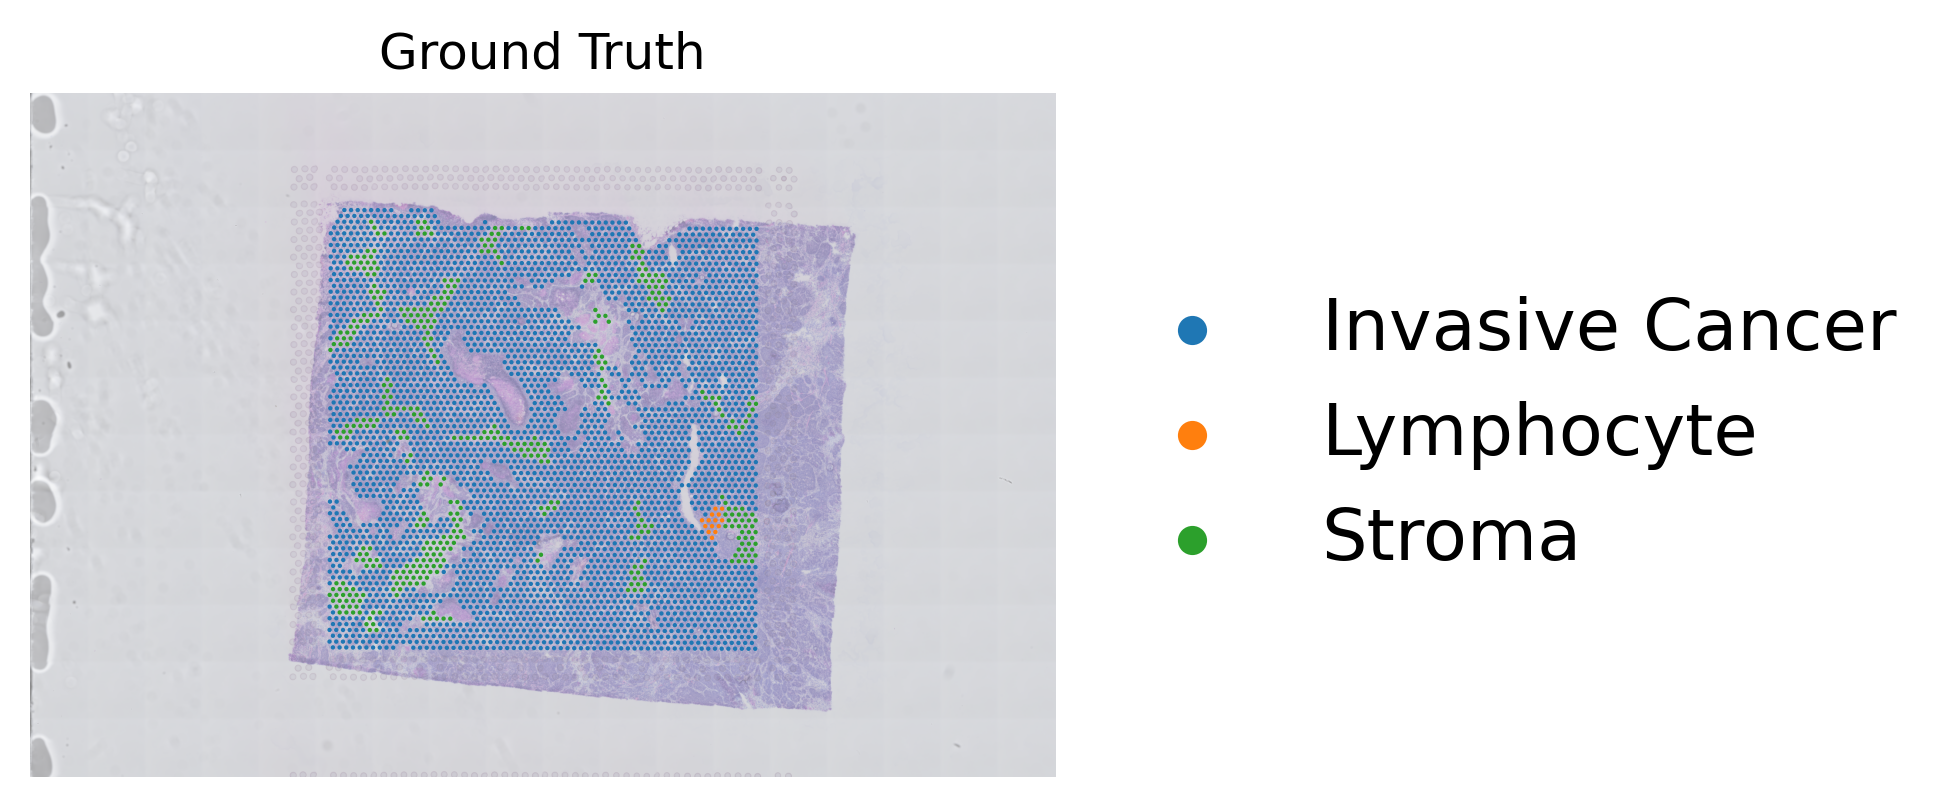

In [7]:
# Hist2ST with Spatial Location Graph only
clustering_on_exp(PAG = False, GAG = False)
# Hist2ST with Pathology Annotation Graph
clustering_on_exp(PAG = True, GAG = False)
# Hist2ST with Gene Expression Similarity Graph
clustering_on_exp(PAG = False, GAG = True)
# Hist2ST with Gene Expression Similarity Graph & Pathology Annotation Graph
clustering_on_exp(PAG = True, GAG = True)

## Visualize

In [ ]:
ls Clustering_fig1

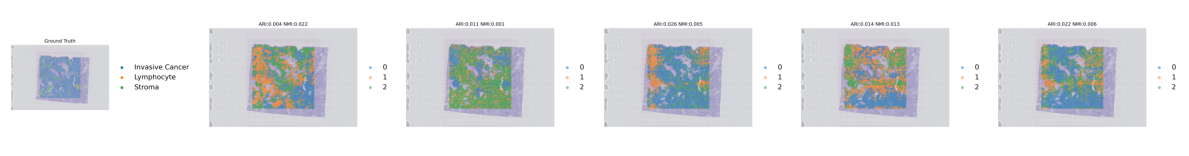

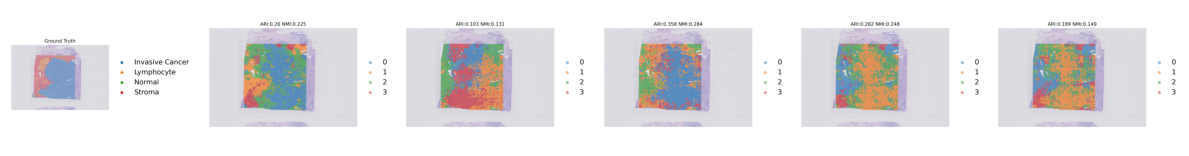

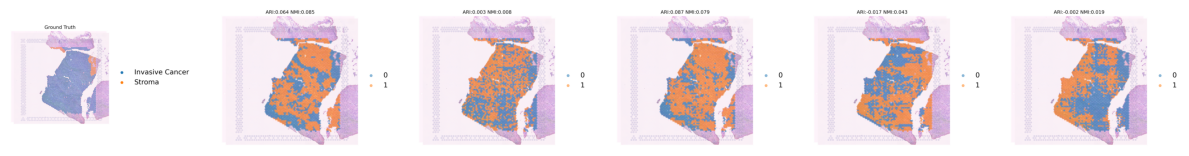

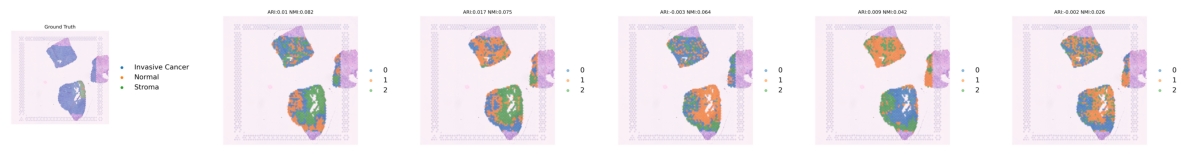

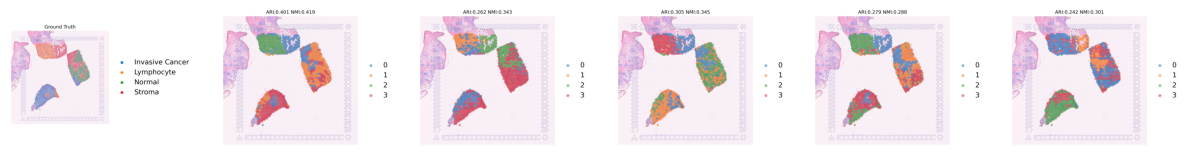

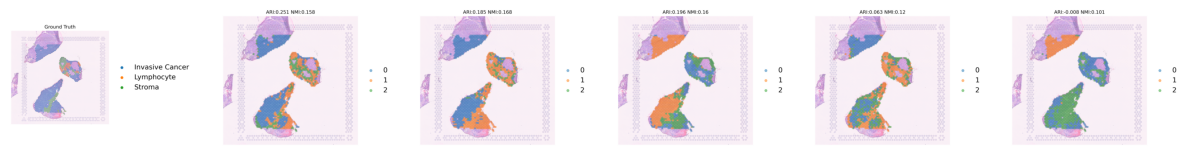

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gc

name_slides = ["1142243F", "CID4290", "CID4465", "CID44971", "CID4535", "1160920F"]
fig_path = "./Clustering_fig1/"
# List of image filenames
for slide in name_slides:
    
    image_files = [f'{slide}_gt.png', f'{slide}_obs.png', f'PAG_False_GAG_False_{slide}_pred.png', f'PAG_False_GAG_True_{slide}_pred.png', f'PAG_True_GAG_False_{slide}_pred.png', f'PAG_True_GAG_True_{slide}_pred.png']
    image_files = [fig_path + file for file in image_files]
        
    # Create subplots
    fig, axs = plt.subplots(1, 6, figsize=(12, 6))

    # Iterate through image files and display them
    for i, image_file in enumerate(image_files):
        img = mpimg.imread(image_file)
        axs[i].imshow(img)
        axs[i].axis('off')
        # axs[i].set_title(image_file)
    gc.collect()
    fig.tight_layout()
    plt.savefig(f"{fig_path}{slide}.pdf", dpi=1200)


In [ ]:
import pandas as pd
PAG = False
GAG = False
obs_res = pd.read_csv(f"./Clustering_fig/PAG_{PAG}_GAG_{GAG}_obs_cluster_res.csv", index_col=0)
obs_res["Graph"] = "Observation"

PAG = False
GAG = False
SLG_res = pd.read_csv(f"./Clustering_fig/PAG_{PAG}_GAG_{GAG}_pred_cluster_res.csv", index_col=0)
SLG_res["Graph"] = "SLG Only"

PAG = True
GAG = False
PAG_res = pd.read_csv(f"./Clustering_fig/PAG_{PAG}_GAG_{GAG}_pred_cluster_res.csv", index_col=0)
PAG_res["Graph"] = "PAG"

PAG = False
GAG = True
GAG_res = pd.read_csv(f"./Clustering_fig/PAG_{PAG}_GAG_{GAG}_pred_cluster_res.csv", index_col=0)
GAG_res["Graph"] = "GAG"

# PAG = True
# GAG = True
# PAG_GAG_res = pd.read_csv(f"./Clustering_fig/PAG_{PAG}_GAG_{GAG}_pred_cluster_res.csv", index_col=0)
# PAG_GAG_res["Graph"] = "PAG & GAG"

df = pd.concat([obs_res, SLG_res, PAG_res, GAG_res])
df


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import gc

gc.collect()
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

# Plot the first figure
sns.barplot(data=df, x="Slides", y="ARI", hue="Graph", ax=axs[0])

# Plot the second figure
sns.barplot(data=df, x="Slides", y="ARI", hue="Graph", ax=axs[1])

# Adjust layout to prevent overlapping
plt.tight_layout()

# Move the legend outside the plot area
for ax in axs:
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, 1.23),
        ncol=7,
    )

# Show the plots
# plt.savefig("GraphBuild.pdf", dpi=300)
# plt.show()